<a href="https://colab.research.google.com/github/b4wolf/NEURALNETS/blob/main/working_copy_PMWeather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.2 MB/s eta 0:00:00


In [2]:
import torch
import folium
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from scipy.spatial.distance import euclidean
import os
import networkx as nx
from torch_geometric.data import Data
import math
from heapq import nsmallest
import pandas as pd
import re
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import scipy.sparse as sparse

In [3]:
import json
import os
import pandas as pd

json_folder = 'WI_weather_coords'
csv_folder = 'clean_WI_data'

weather_dict = {}

for filename in os.listdir(json_folder):
    if filename.endswith('.json'):
        with open(os.path.join(json_folder, filename), 'r') as f:
            data = json.load(f)
            prefix = filename.split('.')[0]
            weather_dict[prefix] = data['lat_lon']


json_folder = './WI_weather_coords'
csv_folder = './clean_WI_data'

weather_data_mapping = {}

for json_filename in os.listdir(json_folder):
    if json_filename.endswith('.json'):
        prefix = json_filename.split('.')[0]
        json_path = os.path.join(json_folder, json_filename)
        with open(json_path, 'r') as f:
            data = json.load(f)
            lat_lon = data['lat_lon']

            if prefix not in weather_data_mapping:
                weather_data_mapping[prefix] = {'lat_lon': None, 'csv_path': None}

            weather_data_mapping[prefix]['lat_lon'] = lat_lon

for csv_filename in os.listdir(csv_folder):
    if csv_filename.endswith('.csv'):
        prefix = csv_filename.split('.')[0]

        if prefix in weather_data_mapping:
            csv_path = os.path.join(csv_folder, csv_filename)
            weather_data_mapping[prefix]['csv_path'] = csv_path


lat_lon_mapping = {}

for json_filename in os.listdir(json_folder):
    if json_filename.endswith('.json'):
        prefix = json_filename.split('.')[0]
        json_path = os.path.join(json_folder, json_filename)
        with open(json_path, 'r') as f:
            data = json.load(f)
            lat_lon_mapping[prefix] = data['lat_lon']

weather_data = {}

for csv_filename in os.listdir(csv_folder):
    if csv_filename.endswith('.csv'):
        prefix = csv_filename.split('.')[0]

        if prefix in lat_lon_mapping:
            csv_path = os.path.join(csv_folder, csv_filename)

            df = pd.read_csv(csv_path)

            df['latitude'] = lat_lon_mapping[prefix][0]
            df['longitude'] = lat_lon_mapping[prefix][1]

            weather_data[prefix] = df


In [4]:
import regex as re
directory_path = '/content/preprocessed_pm'
file_names = [file for file in os.listdir(directory_path) if 'monitor' in file and file.endswith('.csv')]
data_frames = []

for file_name in file_names:
    match = re.match(r'processed_monitor_([0-9.-]+)_([0-9.-]+)\.csv', file_name)
    if match:
        lat, lon = match.groups()
        lat, lon = float(lat), float(lon)
        try:
            df = pd.read_csv(os.path.join(directory_path, file_name))
            df['Latitude'] = lat
            df['Longitude'] = lon
            data_frames.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_name}")
        except pd.errors.EmptyDataError:
            print(f"No data in file: {file_name}")
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
    else:
        print(f"Filename pattern mismatch: {file_name}")


In [5]:
wet_lat_lon = []
pm_lat_lon = []
for df in weather_data:
  wet_lat_lon.append((weather_data[df]['longitude'][0], weather_data[df]['latitude'][0]))

for index, df in enumerate(data_frames):
  pm_lat_lon.append((df['Latitude'][0], df['Longitude'][0]))

In [6]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c

    return distance

In [7]:
#########################################
# Finds the nearest neighbors between
# weather and PM 2.5 stations
#########################################
def find_nearest_neighbors(list1, list2):
    nearest_neighbors = []

    for point1 in list1:
        min_distance = float('inf')
        nearest_neighbor = None

        for point2 in list2:
            distance = haversine(point1[0], point1[1], point2[0], point2[1])
            if distance < min_distance:
                min_distance = distance
                nearest_neighbor = point2
        nearest_neighbors.append((point1, nearest_neighbor, min_distance))

    return nearest_neighbors

list1 = pm_lat_lon
list2 = wet_lat_lon

nearest_neighbors = find_nearest_neighbors(list1, list2)

########################################################
# SHOULD ONLY BE RUN ONCE OTHERWISE WILL CREATE PROBLEMS
########################################################
for index, n in enumerate(nearest_neighbors):
  nearest_neighbors[index] = (pm_lat_lon.index(n[0]), wet_lat_lon.index(n[1]), n[2])
  data_frames[nearest_neighbors[index][0]] = pd.concat([data_frames[nearest_neighbors[index][0]], weather_data[list(weather_data.keys())[nearest_neighbors[index][1]]]], axis=1)

# cleaning the dataframe to only get the information we need
prepped_data_frames = []
for df in data_frames:
  df = df.drop('Unnamed: 0', axis=1) \
    .drop('latitude', axis=1) \
    .drop('longitude', axis=1) \
    .drop('Index', axis=1) \
    .drop('dwpf', axis=1) \
    .drop('relh', axis=1) \
    .drop('alti', axis=1) \
    .drop('feel', axis=1) \
    .drop('drct', axis=1) \
    .drop('sknt', axis=1) \
    .drop('vsby', axis=1) \
    .rename(columns={'Value': 'pm25'})
  print(df.shape)
  prepped_data_frames.append(df)

prepped_data_frames[0]


(8760, 4)
(8760, 4)
(8760, 4)
(8760, 4)
(8760, 4)
(8760, 4)
(8760, 4)
(8760, 4)
(8760, 4)
(8760, 4)
(8760, 4)


,pm25,Latitude,Longitude,tmpf
0,25.3,44.50729,-87.99344,18.0
1,24.6,44.50729,-87.99344,12.0
2,24.3,44.50729,-87.99344,9.0
3,24.2,44.50729,-87.99344,7.0
4,27.5,44.50729,-87.99344,10.9
...,...,...,...,...
8755,14.6,44.50729,-87.99344,28.9
8756,14.6,44.50729,-87.99344,28.9
8757,14.6,44.50729,-87.99344,28.9
8758,14.6,44.50729,-87.99344,28.9


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

stat_train_predictions = []
stat_train_truths = []
stat_test_predictions = []
stat_test_truths = []
train_losses = []
test_losses = []

for df in prepped_data_frames:
  timeseries = df.drop('Latitude', axis=1).drop('Longitude', axis=1).values.astype('float32')
  print(timeseries.shape)
  train_size = int(len(timeseries) * 0.70)
  test_size = len(timeseries) - train_size
  train, test = timeseries[:train_size], timeseries[train_size:]
  def create_dataset(dataset, lookback):
      """Transform a time series into a prediction dataset

      Args:
          dataset: A numpy array of time series, first dimension is the time steps
          lookback: Size of window for prediction
      """
      X, y = [], []
      for i in range(len(dataset)-lookback):
          feature = dataset[i:i+lookback]
          target = dataset[i+1:i+lookback+1]
          X.append(feature)
          y.append(target)
      return torch.tensor(X), torch.tensor(y)

  lookback = 7
  X_train, y_train = create_dataset(train, lookback=lookback)
  X_test, y_test = create_dataset(test, lookback=lookback)

  stat_train_truths.append(y_train[:, -1, :].numpy())
  stat_test_truths.append(y_test[:, -1, :].numpy())

  class LSTM(nn.Module):
      def __init__(self):
          super().__init__()
          self.lstm = nn.LSTM(input_size=2, hidden_size=64, num_layers=3, batch_first=True)
          self.linear = nn.Linear(64, 2)
      def forward(self, x):
          x, _ = self.lstm(x)
          x = self.linear(x)
          return x

  model = LSTM()
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.MSELoss()
  loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

  n_epochs = 10
  for epoch in range(n_epochs):
      model.train()
      losses = []
      for X_batch, y_batch in loader:
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          losses.append(np.sqrt(loss.detach().numpy()))
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      train_losses.append(np.mean(losses))
      # Validation
      model.eval()
      with torch.no_grad():
          y_pred = model(X_train)
          train_rmse = np.sqrt(loss_fn(y_pred, y_train))
          test_losses.append(train_rmse)
          y_pred = model(X_test)
          test_rmse = np.sqrt(loss_fn(y_pred, y_test))
      print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

  with torch.no_grad():
    y_pred = model(X_train)
    stat_train_predictions.append(y_pred[:, -1, :])
    y_pred = model(X_test)
    print(type(y_pred))
    stat_test_predictions.append(y_pred[:, -1, :])

(8760, 2)


<ipython-input-8-5740caf49e3a>:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0: train RMSE 15.5051, test RMSE 10.1380
Epoch 1: train RMSE 8.0506, test RMSE 4.4426
Epoch 2: train RMSE 5.2614, test RMSE 2.8176
Epoch 3: train RMSE 3.9523, test RMSE 2.2658
Epoch 4: train RMSE 3.2863, test RMSE 2.0614
Epoch 5: train RMSE 2.8403, test RMSE 1.9696
Epoch 6: train RMSE 2.6004, test RMSE 2.0173
Epoch 7: train RMSE 2.5428, test RMSE 2.0250
Epoch 8: train RMSE 2.2076, test RMSE 1.8648
Epoch 9: train RMSE 2.1640, test RMSE 1.8898
<class 'torch.Tensor'>
(8760, 2)
Epoch 0: train RMSE 16.6972, test RMSE 11.7490
Epoch 1: train RMSE 8.2670, test RMSE 5.1189
Epoch 2: train RMSE 5.0837, test RMSE 3.1063
Epoch 3: train RMSE 3.6374, test RMSE 2.4188
Epoch 4: train RMSE 2.8780, test RMSE 2.1787
Epoch 5: train RMSE 2.4633, test RMSE 2.0807
Epoch 6: train RMSE 2.2018, test RMSE 2.0199
Epoch 7: train RMSE 2.0485, test RMSE 2.0013
Epoch 8: train RMSE 1.9778, test RMSE 2.0380
Epoch 9: train RMSE 1.9957, test RMSE 2.1114
<class 'torch.Tensor'>
(8760, 2)
Epoch 0: train RMSE 16.5659, t

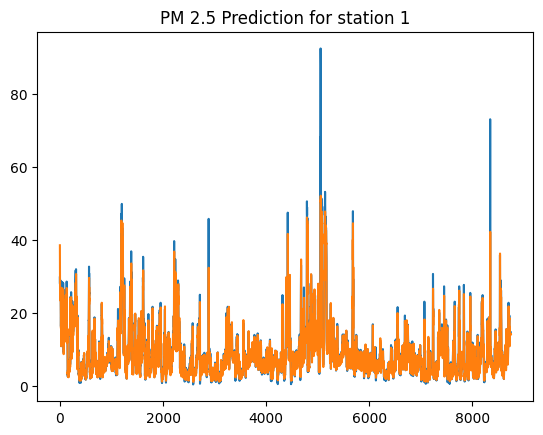

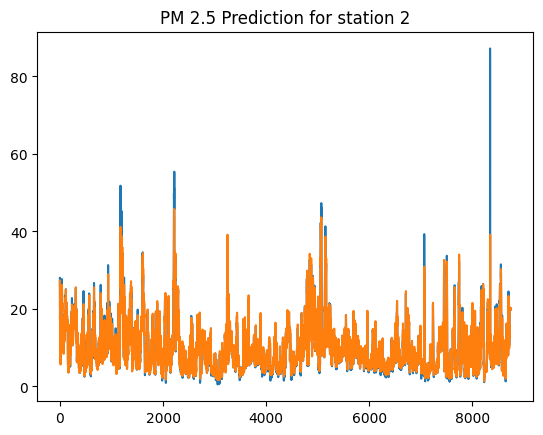

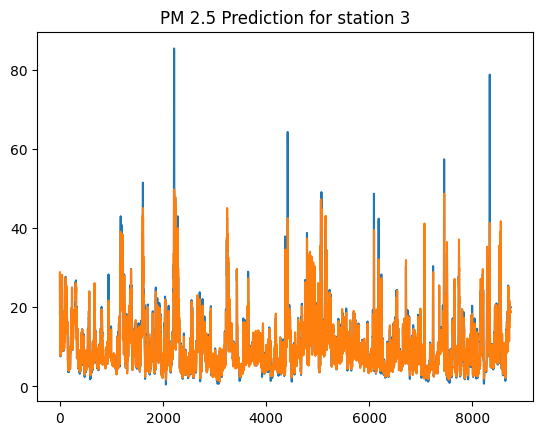

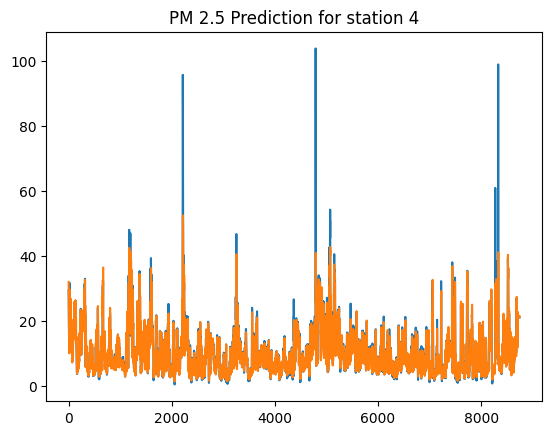

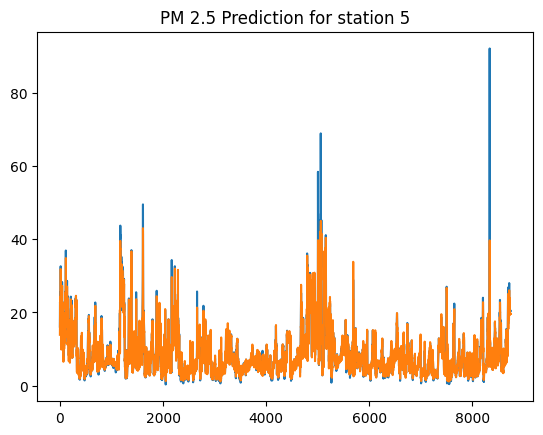

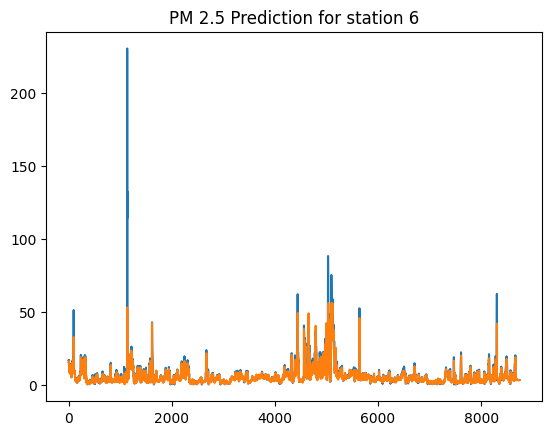

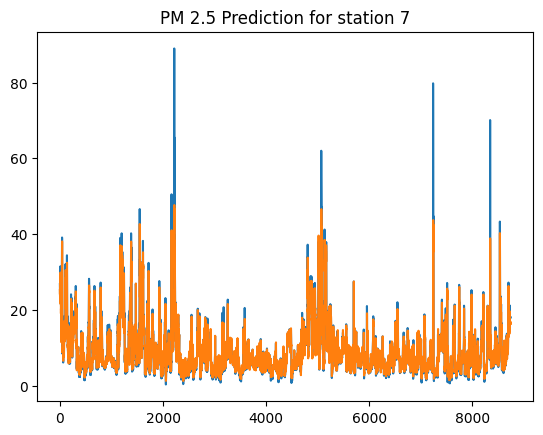

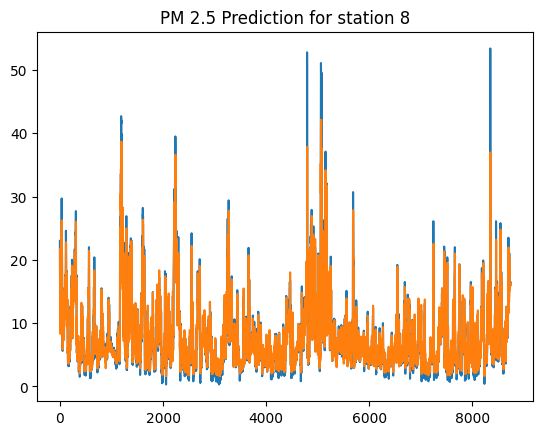

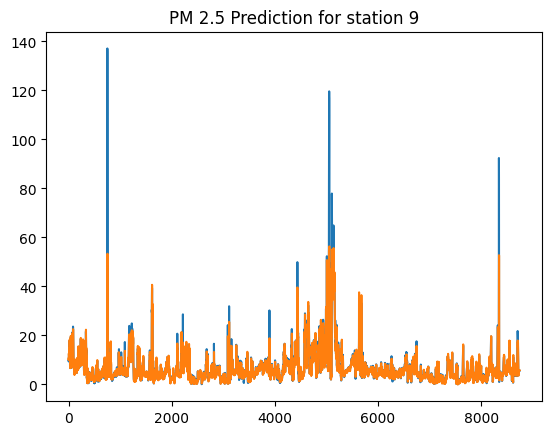

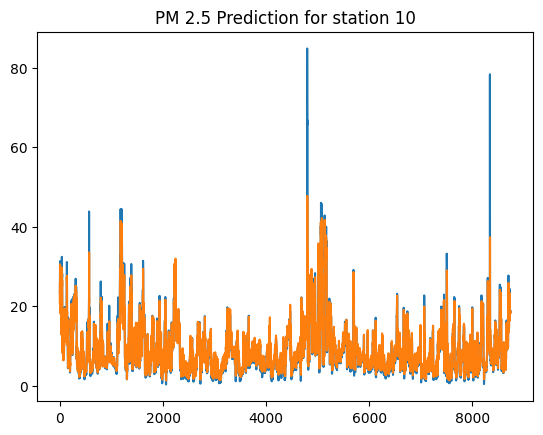

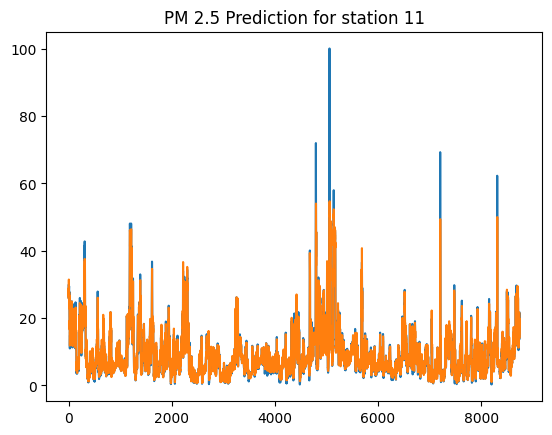

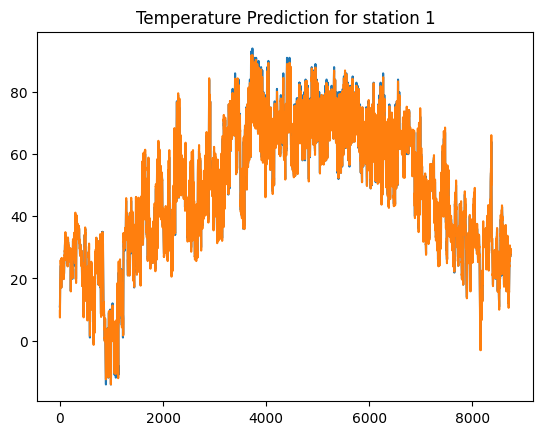

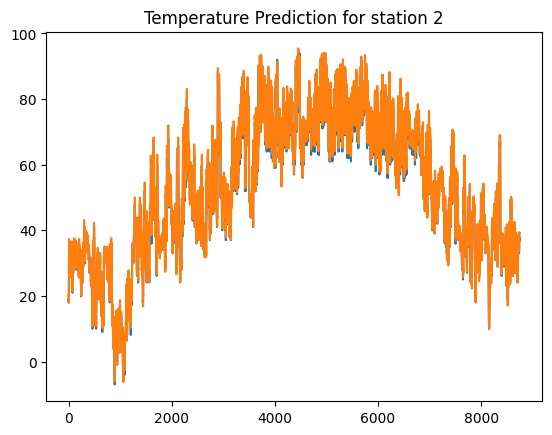

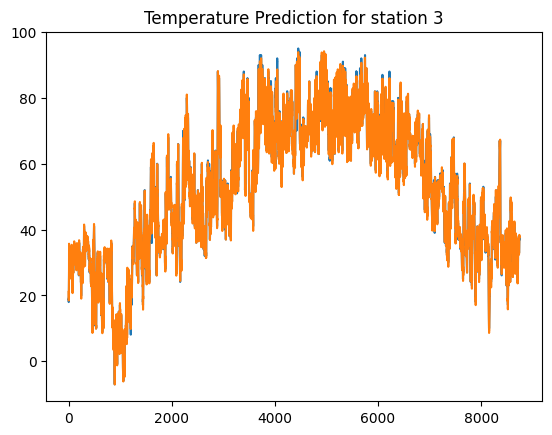

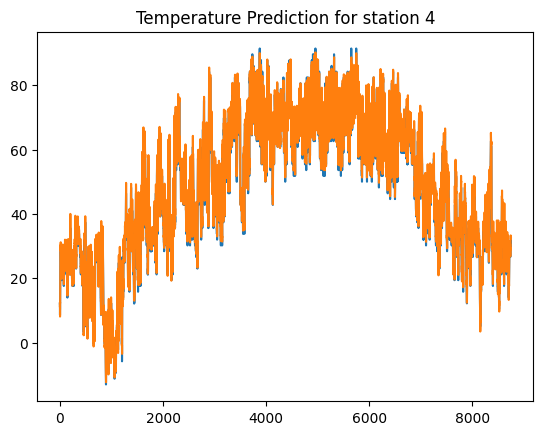

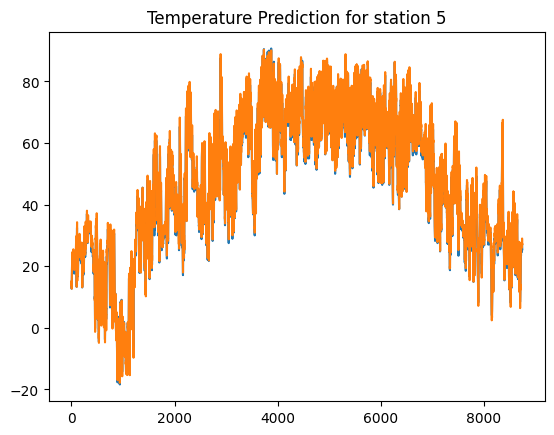

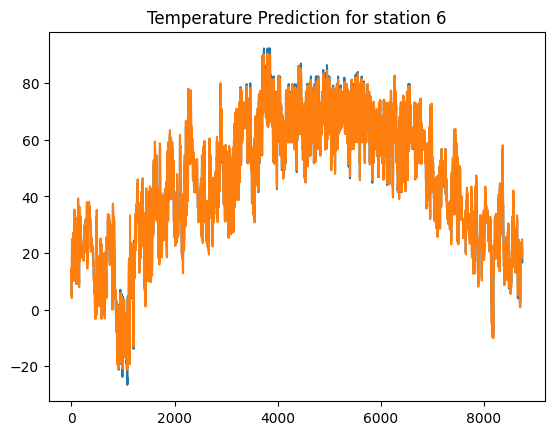

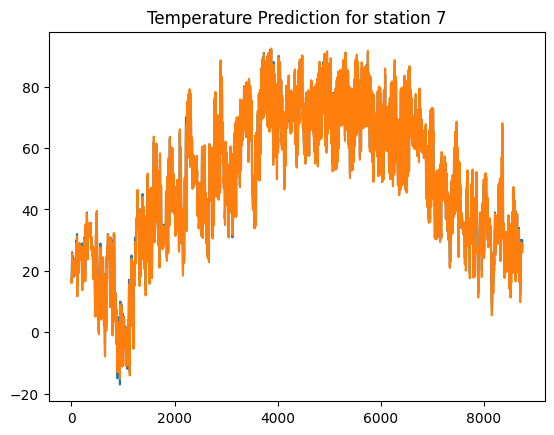

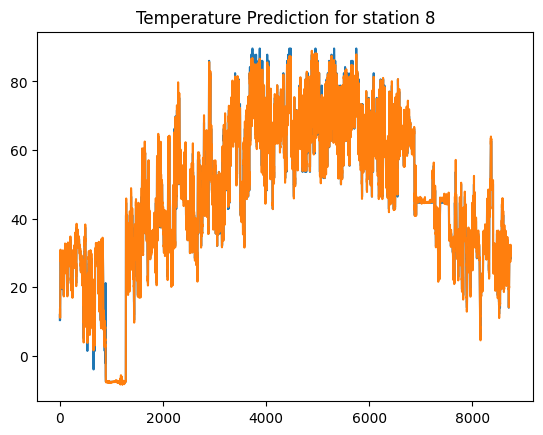

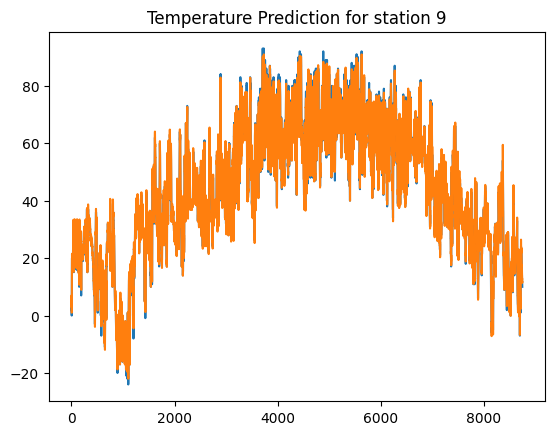

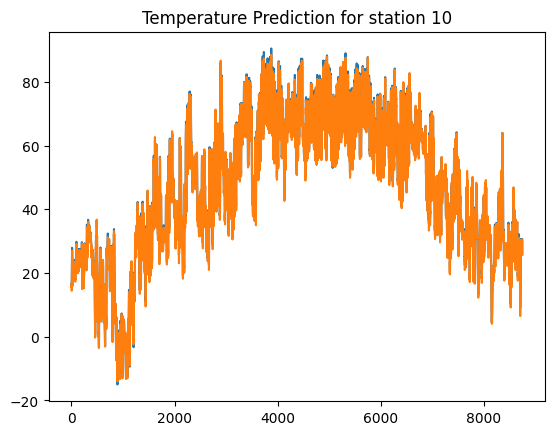

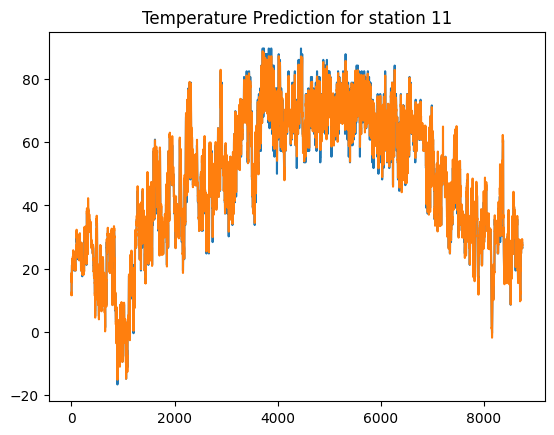

In [9]:
for i in range(11):
  plt.plot(np.hstack((stat_train_truths[i][:, 0], stat_test_truths[i][:, 0])))
  plt.plot(np.hstack((stat_train_predictions[i][:,0], stat_test_predictions[i][:, 0])))
  plt.title(f'PM 2.5 Prediction for station {i+1}')
  plt.show()

for i in range(11):
  plt.plot(np.hstack((stat_train_truths[i][:, 1], stat_test_truths[i][:, 1])))
  plt.plot(np.hstack((stat_train_predictions[i][:,1], stat_test_predictions[i][:, 1])))
  plt.title(f'Temperature Prediction for station {i+1}')
  plt.show()